Idealised 2-D viscoelastic loading problem in an annulus
=======================================================

In this tutorial, we examine an idealised 2-D loading problem in an annulus domain.

This example focusses on differences between running simulations in a 2-D annulus and 2-D Cartesian domain.
These can be summarised as follows:
1. The geometry of the problem - i.e. the computational mesh.
2. The radial direction of gravity (as opposed to the vertical direction in a Cartesian domain).
3. Solving a problem with laterally varying viscosity.
4. Accounting for a (rotational) velocity nullspace.

This example
-------------
Let's get started!
The first step is to import the gadopt module, which
provides access to Firedrake and associated functionality.

In [1]:
from gadopt import *
from gadopt.utility import step_func, vertical_component

We generate a circular manifold mesh (with 180 elements) and extrude in the radial direction,
using the optional keyword argument `extrusion_type`, forming 32 layers. To better represent the
curvature of the domain and ensure accuracy of our quadratic representation of incremental displacement, we
approximate the curved cylindrical shell domain quadratically, using the optional keyword argument `degree`$=2$.

As this problem is not formulated in a Cartesian geometry we set the `mesh.cartesian`
attribute to `False`. This ensures the correct configuration of a radially inward vertical direction.

In [2]:
# Set up geometry:
rmin = 3480e3
rmax = 6371e3
D = rmax-rmin
nz = 32
ncells = 180
dz = D / nz

# Construct a circle mesh and then extrude into a cylinder:
surface_mesh = CircleManifoldMesh(ncells, radius=rmin, degree=2, name='surface_mesh')
mesh = ExtrudedMesh(surface_mesh, layers=nz, layer_height=dz, extrusion_type='radial')

boundary = get_boundary_ids(mesh)
mesh.cartesian = False

We next set up the function spaces, and specify functions to hold our solutions.

In [3]:
# Set up function spaces - currently using the bilinear Q2Q1 element pair:
V = VectorFunctionSpace(mesh, "CG", 2)  # (Incremental) Displacement function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
S = TensorFunctionSpace(mesh, "DQ", 2)  # (Discontinuous) Stress tensor function space (tensor)
R = FunctionSpace(mesh, "R", 0)  # Real function space (for constants)

Z = MixedFunctionSpace([V, W])  # Mixed function space.

z = Function(Z)  # A field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Incremental Displacement")
z.subfunctions[1].rename("Pressure")

displacement = Function(V, name="displacement").assign(0)
stress_old = Function(S, name="stress_old").assign(0)

We can output function space information, for example the number of degrees
of freedom (DOF).

In [4]:
# Output function space information:
log("Number of Incremental Displacement DOF:", V.dim())
log("Number of Pressure DOF:", W.dim())
log("Number of Velocity and Pressure DOF:", V.dim()+W.dim())

Number of Incremental Displacement DOF: 46800
Number of Pressure DOF: 5940
Number of Velocity and Pressure DOF: 52740


We can now visualise the resulting mesh.

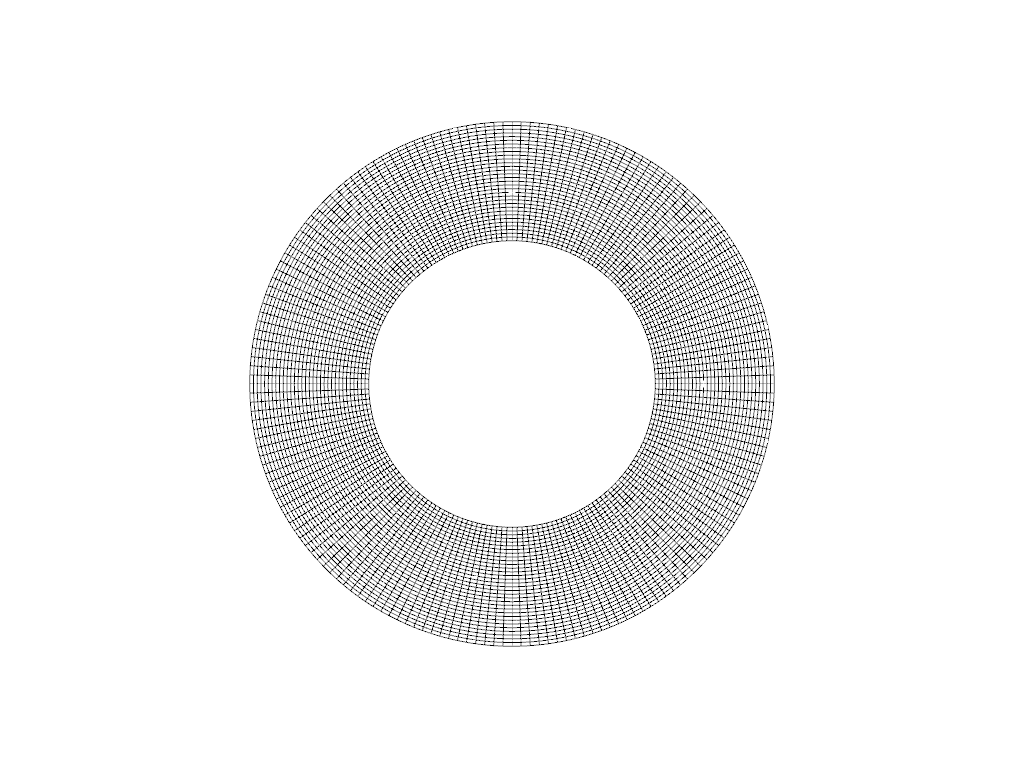

In [5]:
import pyvista as pv
import matplotlib.pyplot as plt

VTKFile("mesh.pvd").write(Function(V))
mesh_data = pv.read("mesh/mesh_0.vtu")
edges = mesh_data.extract_all_edges()
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(edges, color="black")
plotter.camera_position = "xy"
plotter.show(jupyter_backend="static", interactive=False)

Let's start initialising some parameters. First of all let's get the (symbolic) spatial coordinates of the mesh

In [6]:
X = SpatialCoordinate(mesh)

Now we can set up the background profiles for the material properties.
In this case the density and shear modulus vary in the vertical direction.
We will approximate the series of layers using a smooth tanh function with a width of 40 km.
The layer properties specified are from spada et al. (2011).
N.b. that we have modified the viscosity of the Lithosphere viscosity from
Spada et al. (2011) because we are using coarse grid resolution.

In [7]:
radius_values = [6371e3, 6301e3, 5951e3, 5701e3]
density_values = [3037, 3438, 3871, 4978]
shear_modulus_values = [0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11]
viscosity_values = [2, -2, -2, -1.698970004]  # viscosity = 1e23 * 10**viscosity_values


def initialise_background_field(field, background_values, vertical_tanh_width=40e3):
    profile = background_values[0]
    sharpness = 1 / vertical_tanh_width
    depth = sqrt(X[0]**2 + X[1]**2)-radius_values[0]
    for i in range(1, len(background_values)):
        centre = radius_values[i] - radius_values[0]
        mag = background_values[i] - background_values[i-1]
        profile += step_func(depth, centre, mag, increasing=False, sharpness=sharpness)

    field.interpolate(profile)


density = Function(W, name="density")
initialise_background_field(density, density_values)

shear_modulus = Function(W, name="shear modulus")
initialise_background_field(shear_modulus, shear_modulus_values)

Let's have a quick look at the density field using pyvista.

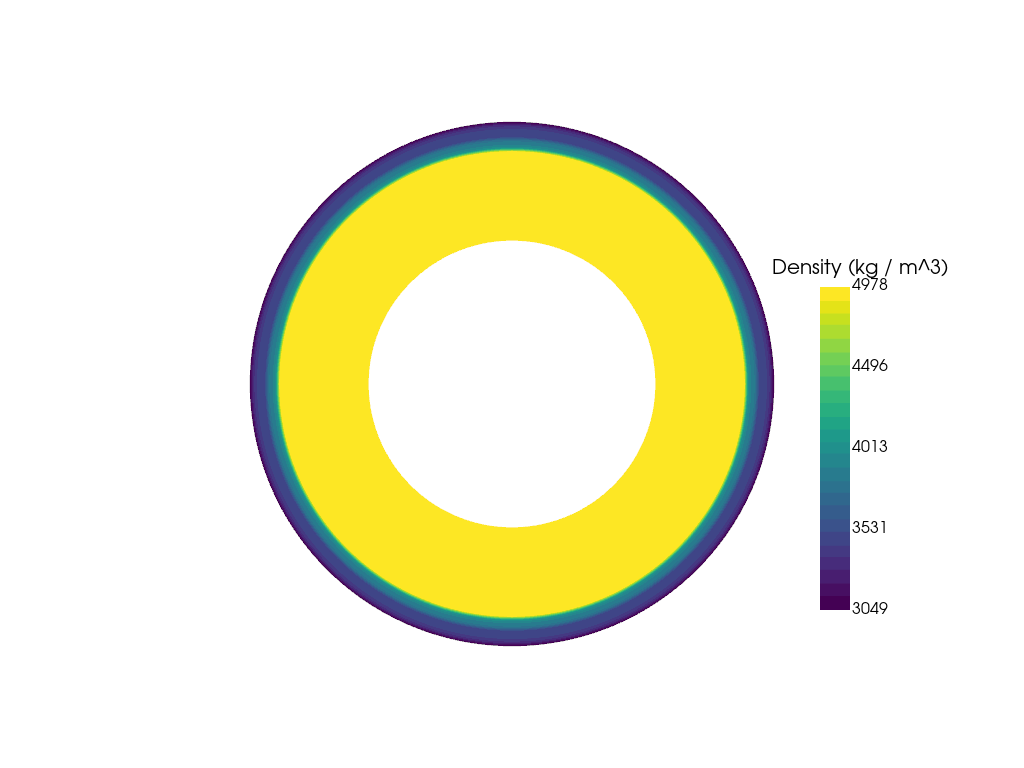

In [8]:
# Read the PVD file
density_file = VTKFile('density.pvd').write(density)
reader = pv.get_reader("density.pvd")
data = reader.read()[0]  # MultiBlock mesh with only 1 block

# Create a plotter object
plotter = pv.Plotter(shape=(1, 1), border=False, notebook=True, off_screen=False)

# Make a colour map
boring_cmap = plt.get_cmap("viridis", 25)
# Add the warped displacement field to the frame
plotter.add_mesh(
    data,
    component=None,
    lighting=False,
    show_edges=False,
    cmap=boring_cmap,
    scalar_bar_args={
        "title": 'Density (kg / m^3)',
        "position_x": 0.8,
        "position_y": 0.2,
        "vertical": True,
        "title_font_size": 20,
        "label_font_size": 16,
        "fmt": "%.0f",
        "font_family": "arial",
    }
)
plotter.camera_position = 'xy'
plotter.show(jupyter_backend="static", interactive=False)
# Closes and finalizes movie
plotter.close()

Next let's initialise the viscosity field. In this tutorial we are
going to make things a bit more interesting by using a laterally
varying viscosity field. We'll put some regions of low viscosity
near the South Pole (inspired by West Antarctica) as well as in the lower mantle.
We've also put some relatively higher viscosity patches of mantle in the
northern hemisphere to represent a downgoing slab.

In [9]:
def bivariate_gaussian(x, y, mu_x, mu_y, sigma_x, sigma_y, rho, normalised_area=False):
    arg = ((x-mu_x)/sigma_x)**2 - 2*rho*((x-mu_x)/sigma_x)*((y-mu_y)/sigma_y) + ((y-mu_y)/sigma_y)**2
    numerator = exp(-1/(2*(1-rho**2))*arg)
    if normalised_area:
        denominator = 2*pi*sigma_x*sigma_y*(1-rho**2)**0.5
    else:
        denominator = 1
    return numerator / denominator


def setup_heterogenous_viscosity(viscosity):
    heterogenous_viscosity_field = Function(viscosity.function_space(), name='viscosity')
    antarctica_x, antarctica_y = -2e6, -5.5e6

    low_viscosity_antarctica = bivariate_gaussian(X[0], X[1], antarctica_x, antarctica_y, 1.5e6, 0.5e6, -0.4)
    heterogenous_viscosity_field.interpolate(-3*low_viscosity_antarctica + viscosity * (1-low_viscosity_antarctica))

    llsvp1_x, llsvp1_y = 3.5e6, 0
    llsvp1 = bivariate_gaussian(X[0], X[1], llsvp1_x, llsvp1_y, 0.75e6, 1e6, 0)
    heterogenous_viscosity_field.interpolate(-3*llsvp1 + heterogenous_viscosity_field * (1-llsvp1))

    llsvp2_x, llsvp2_y = -3.5e6, 0
    llsvp2 = bivariate_gaussian(X[0], X[1], llsvp2_x, llsvp2_y, 0.75e6, 1e6, 0)
    heterogenous_viscosity_field.interpolate(-3*llsvp2 + heterogenous_viscosity_field * (1-llsvp2))

    slab_x, slab_y = 3e6, 4.5e6
    slab = bivariate_gaussian(X[0], X[1], slab_x, slab_y, 0.7e6, 0.35e6, 0.7)
    heterogenous_viscosity_field.interpolate(-1*slab + heterogenous_viscosity_field * (1-slab))

    high_viscosity_craton_x, high_viscosity_craton_y = 0, 6.2e6
    high_viscosity_craton = bivariate_gaussian(X[0], X[1], high_viscosity_craton_x, high_viscosity_craton_y, 1.5e6, 0.5e6, 0.2)
    heterogenous_viscosity_field.interpolate(-1*high_viscosity_craton + heterogenous_viscosity_field * (1-high_viscosity_craton))

    return heterogenous_viscosity_field


normalised_viscosity = Function(W, name="Normalised viscosity")
initialise_background_field(normalised_viscosity, viscosity_values)
normalised_viscosity = setup_heterogenous_viscosity(normalised_viscosity)

viscosity = Function(normalised_viscosity, name="viscosity").interpolate(1e23*10**normalised_viscosity)


Now let's plot the normalised viscosity viscosity field in log space
(we have divided the viscosity by 1x10$^{23}$ Pa s). Although we are using a fairly
coarse mesh we are able to capture the key features of the viscosity field.

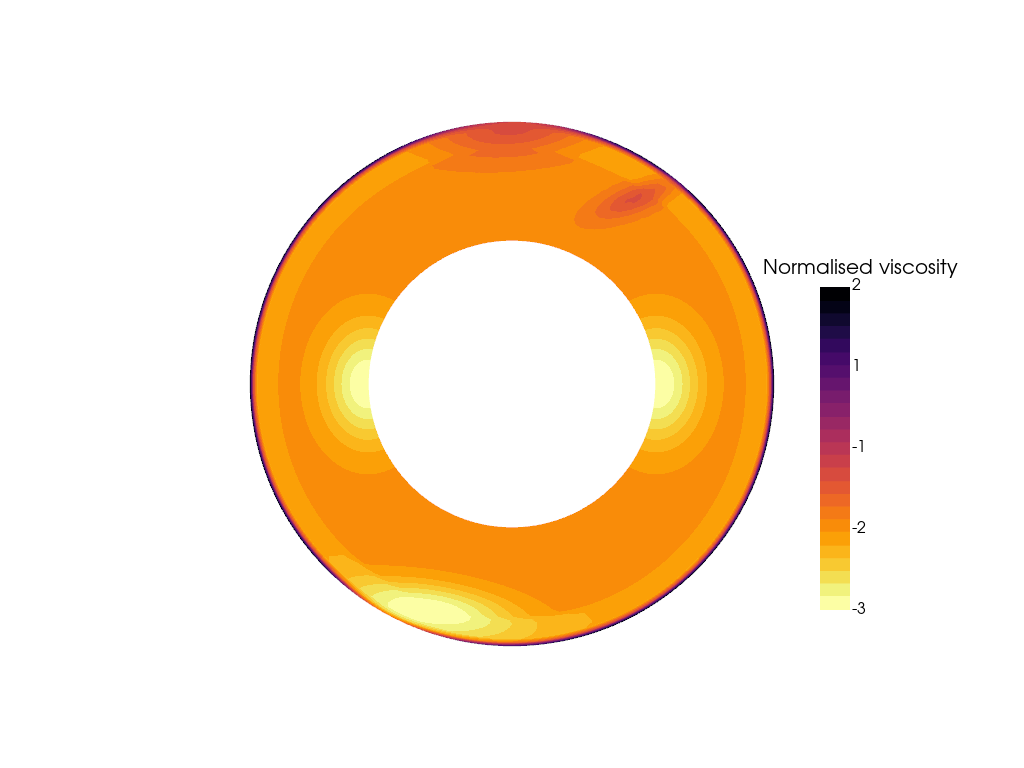

In [10]:
# Read the PVD file
visc_file = VTKFile('viscosity.pvd').write(normalised_viscosity)
reader = pv.get_reader("viscosity.pvd")
data = reader.read()[0]  # MultiBlock mesh with only 1 block

# Create a plotter object
plotter = pv.Plotter(shape=(1, 1), border=False, notebook=True, off_screen=False)

# Make a colour map
boring_cmap = plt.get_cmap("inferno_r", 25)
# Add the warped displacement field to the frame
plotter.add_mesh(
    data,
    component=None,
    lighting=False,
    show_edges=False,
    cmap=boring_cmap,
    scalar_bar_args={
        "title": 'Normalised viscosity',
        "position_x": 0.8,
        "position_y": 0.2,
        "vertical": True,
        "title_font_size": 20,
        "label_font_size": 16,
        "fmt": "%.0f",
        "font_family": "arial",
    }
)
plotter.camera_position = 'xy'
plotter.show(jupyter_backend="static", interactive=False)
# Closes and finalizes movie
plotter.close()

Now let's setup the ice load. For this tutorial we will have two synthetic ice sheets.
Let's put one a larger one over the South Pole, with a total horizontal
extent of 40 $^\circ$ and a maximum thickness of 2 km, and a smaller one offset from the
North Pole with a width of 20 $^\circ$ and a maximum thickness of 1 km. To simplify things let's
keep the ice load fixed in time.

In [11]:
rho_ice = 931
g = 9.8125
Hice1 = 1000
Hice2 = 2000
year_in_seconds = Constant(3600 * 24 * 365.25)
# Disc ice load but with a smooth transition given by a tanh profile
disc_halfwidth1 = (2*pi/360) * 10  # Disk half width in radians
disc_halfwidth2 = (2*pi/360) * 20  # Disk half width in radians
surface_dx = 200*1e3
ncells = 2*pi*radius_values[0] / surface_dx
surface_resolution_radians = 2*pi / ncells
colatitude = atan2(X[0], X[1])
disc1_centre = (2*pi/360) * 25  # centre of disc1
disc2_centre = pi  # centre of disc2
disc1 = 0.5*(1-tanh((abs(colatitude-disc1_centre) - disc_halfwidth1) / (2*surface_resolution_radians)))
disc2 = 0.5*(1-tanh((abs(abs(colatitude)-disc2_centre) - disc_halfwidth2) / (2*surface_resolution_radians)))
ice_load = rho_ice * g * (Hice1 * disc1 + Hice2 * disc2)

Let's visualise the ice thickness using pyvista, by plotting a ring outside our synthetic Earth.

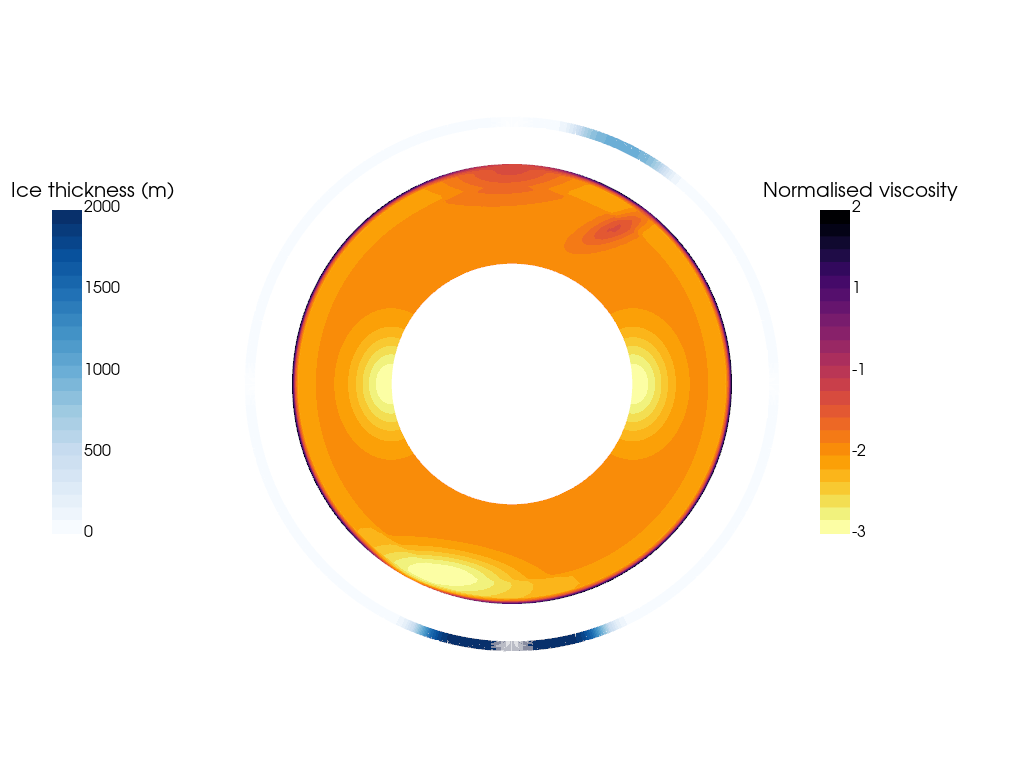

In [12]:
def make_ice_ring(reader):
    data = reader.read()[0]

    normal = [0, 0, 1]
    polar = [rmax-dz/2, 0, 0]
    center = [0, 0, 0]
    angle = 360.0
    res = 10000
    arc = pv.CircularArcFromNormal(center, res, normal, polar, angle)

    arc_data = arc.sample(data)

    # Stretch line by 20%
    transform_matrix = np.array(
        [
            [1.2, 0, 0, 0],
            [0, 1.2, 0, 0],
            [0, 0, 1.2, 0],
            [0, 0, 0, 1],
        ]
    )
    return arc_data.transform(transform_matrix)


def plot_ice_ring(plotter, ice_ring, scalar="Ice thickness"):
    ice_cmap = plt.get_cmap("Blues", 25)

    plotter.add_mesh(
        ice_ring,
        scalars=scalar,
        line_width=10,
        cmap=ice_cmap,
        clim=[0, 2000],
        scalar_bar_args={
            "title": 'Ice thickness (m)',
            "position_x": 0.05,
            "position_y": 0.3,
            "vertical": True,
            "title_font_size": 20,
            "label_font_size": 16,
            "fmt": "%.0f",
            "font_family": "arial",
        }
    )


# Write ice thicknesss .pvd file
ice_thickness = Function(W, name="Ice thickness").interpolate(Hice1 * disc1 + Hice2 * disc2)
zero_ice_thickness = Function(W, name="zero").assign(0)  # Used for plotting later
ice_thickness_file = VTKFile('ice.pvd').write(ice_thickness, zero_ice_thickness)

ice_reader = pv.get_reader("ice.pvd")
ice_ring = make_ice_ring(ice_reader)

reader = pv.get_reader("viscosity.pvd")
data = reader.read()[0]  # MultiBlock mesh with only 1 block

# Create a plotter object
plotter = pv.Plotter(shape=(1, 1), border=False, notebook=True, off_screen=False)

# Make a colour map
boring_cmap = plt.get_cmap("inferno_r", 25)
# Add the warped displacement field to the frame
plotter.add_mesh(
    data,
    component=None,
    scalars=None,
    lighting=False,
    show_edges=False,
    cmap=boring_cmap,
    scalar_bar_args={
        "title": 'Normalised viscosity',
        "position_x": 0.8,
        "position_y": 0.3,
        "vertical": True,
        "title_font_size": 20,
        "label_font_size": 16,
        "fmt": "%.0f",
        "font_family": "arial",
    }
)

plot_ice_ring(plotter, ice_ring)

plotter.camera_position = 'xy'
plotter.show(jupyter_backend="static", interactive=False)
# Closes and finalizes movie
plotter.close()

Let's setup the timestepping parameters with a timestep of 250 years and an output frequency of 1000 years.

In [13]:
# Timestepping parameters
Tstart = 0
time = Function(R).assign(Tstart * year_in_seconds)

dt_years = 250
dt = Constant(dt_years * year_in_seconds)
Tend_years = 10e3
Tend = Constant(Tend_years * year_in_seconds)
dt_out_years = 1e3
dt_out = Constant(dt_out_years * year_in_seconds)

max_timesteps = round((Tend - Tstart * year_in_seconds) / dt)
log("max timesteps: ", max_timesteps)

output_frequency = round(dt_out / dt)
log("output_frequency:", output_frequency)
log(f"dt: {float(dt / year_in_seconds)} years")
log(f"Simulation start time: {Tstart} years")

max timesteps:  40
output_frequency: 4
dt: 250.0 years
Simulation start time: 0 years


We can now define the boundary conditions to be used in this
simulation.  Let's set the bottom and side boundaries to be free
slip with no normal flow $\textbf{u} \cdot \textbf{n} =0$. By passing the string `ux` and `uy`,
G-ADOPT knows to specify these as Strong Dirichlet boundary conditions.

For the top surface we need to specify a normal stress, i.e. the weight of the ice load, as well as
indicating this is a free surface.

The `delta_rho_fs` option accounts for the density contrast across the free surface whether there
is ice or air above a particular region of the mantle.

In [14]:
# Setup boundary conditions
exterior_density = rho_ice * (disc1+disc2)
stokes_bcs = {boundary.top: {'normal_stress': ice_load, 'free_surface': {'delta_rho_fs': density - exterior_density}},
              boundary.bottom: {'un': 0}
              }

We also need to specify a G-ADOPT approximation which sets up the various parameters and fields needed for the viscoelastic loading problem.

In [15]:
approximation = SmallDisplacementViscoelasticApproximation(density, shear_modulus, viscosity, g=g)

As noted above, with a free-slip boundary condition on both boundaries, one can add an arbitrary rotation
of the form $(-y, x)=r\hat{\mathbf{\theta}}$ to the velocity
solution. These lead to null-modes (eigenvectors) for the linear system, rendering the resulting matrix singular.
In preconditioned Krylov methods these null-modes must be subtracted from the approximate solution at
every iteration. We do that below, setting up a nullspace object, specifying the `rotational` keyword argument to be
True. Note that we do not include a pressure nullspace as the top surface of the model is open.

In [16]:
Z_nullspace = create_stokes_nullspace(Z, closed=False, rotational=True)

Given the increased computational expense (typically requiring more degrees of freedom) in a 2-D annulus domain,
G-ADOPT defaults to iterative solver parameters. As noted in our previous 3-D Cartesian tutorial, G-ADOPT's
iterative solver setup is configured to use the GAMG preconditioner for the velocity block of the Stokes system,
to which we must provide near-nullspace information, which, in 2-D, consists of two rotational and two
translational modes.

In [17]:
Z_near_nullspace = create_stokes_nullspace(Z, closed=False, rotational=True, translations=[0, 1])

We finally come to solving the variational problem, with solver
objects for the Stokes system created. We pass in the solution fields `z` and various fields needed for the solve
along with the approximation, timestep and boundary conditions.


In [18]:
stokes_solver = ViscoelasticStokesSolver(z, stress_old, displacement, approximation,
                                         dt, bcs=stokes_bcs, constant_jacobian=True,
                                         nullspace=Z_nullspace, transpose_nullspace=Z_nullspace,
                                         near_nullspace=Z_near_nullspace)

We next set up our output, in VTK format. This format can be read by programs like pyvista and Paraview.

In [19]:
# Create a velocity function for plotting
velocity = Function(V, name="velocity")
velocity.interpolate(z.subfunctions[0]/dt)
# Create output file
output_file = VTKFile("output.pvd")
output_file.write(*z.subfunctions, displacement, velocity)

plog = ParameterLog("params.log", mesh)
plog.log_str(
    "timestep time dt u_rms u_rms_surf ux_max disp_min disp_max"
)

checkpoint_filename = "viscoelastic_loading-chk.h5"

gd = GeodynamicalDiagnostics(z, density, boundary.bottom, boundary.top)

# Initialise a (scalar!) function for logging vertical displacement
U = FunctionSpace(mesh, "CG", 2)  # (Incremental) Displacement function space (scalar)
vertical_displacement = Function(U, name="Vertical displacement")

Now let's run the simulation! At each step we call `solve` to calculate the incremental displacement and
pressure fields. This will update the displacement at the surface and stress values accounting for the time
dependent Maxwell consitutive equation.

In [20]:
for timestep in range(max_timesteps+1):

    stokes_solver.solve()

    time.assign(time+dt)

    if timestep % output_frequency == 0:
        # First output step is after one solve i.e. roughly elastic displacement
        # provided dt < maxwell time.
        log("timestep", timestep)

        velocity.interpolate(z.subfunctions[0]/dt)
        output_file.write(*z.subfunctions, displacement, velocity)

        with CheckpointFile(checkpoint_filename, "w") as checkpoint:
            checkpoint.save_function(z, name="Stokes")
            checkpoint.save_function(displacement, name="Displacement")
            checkpoint.save_function(stress_old, name="Deviatoric stress")

    vertical_displacement.interpolate(vertical_component(displacement))

    # Log diagnostics:
    plog.log_str(
        f"{timestep} {float(time)} {float(dt)} "
        f"{gd.u_rms()} {gd.u_rms_top()} {gd.ux_max(boundary.top)} "
        f"{vertical_displacement.dat.data.min()} "
        f"{vertical_displacement.dat.data.max()} "
    )

timestep 0


timestep 4


timestep 8


timestep 12


timestep 16


timestep 20


timestep 24


timestep 28


timestep 32


timestep 36


timestep 40


Let's use the python package *PyVista* to plot the magnitude of the displacement field through time. We will use the
calculated displacement to artifically scale the mesh. We have exaggerated the stretching by a factor of 1500, **BUT...**
it is important to remember this is just for ease of visualisation - the mesh is not moving in reality!

In [21]:
import matplotlib.pyplot as plt
import pyvista as pv

# Read the PVD file
reader = pv.get_reader("output.pvd")
data = reader.read()[0]  # MultiBlock mesh with only 1 block

# Create a plotter object
plotter = pv.Plotter(shape=(1, 1), border=False, notebook=True, off_screen=False)

# Open a gif
plotter.open_gif("displacement_warp.gif")

# Make a colour map
boring_cmap = plt.get_cmap("inferno_r", 25)

# Fix camera in default position otherwise mesh appears to jumpy around!
#plotter.camera_position = 'xy'

# Make a list of output times (non-uniform because also
# outputing first (quasi-elastic) solve
times = [0, dt_years]
for i in range(len(reader.time_values)):
    times.append((i+1)*1000 )


for i in range(len(reader.time_values)):
    print("Step: ", i)
    reader.set_active_time_point(i)
    data = reader.read()[0]
    # Artificially warp the output data in the vertical direction by the free surface height
    # Note the mesh is not really moving!
    warped = data.warp_by_vector(vectors="displacement", factor=1500)
    arrows = warped.glyph(orient="velocity", scale="velocity", factor=1e14, tolerance=0.01)
    plotter.add_mesh(arrows, color="grey", lighting=False)

    # Add the warped displacement field to the frame
    plotter.add_mesh(
        warped,
        scalars="displacement",
        component=None,
        lighting=False,
       # show_edges=True,
        clim=[0, 600],
        cmap=boring_cmap,
        scalar_bar_args={
            "title": 'Displacement (m)',
            "position_x": 0.85,
            "position_y": 0.3,
            "vertical": True,
            "title_font_size": 20,
            "label_font_size": 16,
            "fmt": "%.0f",
            "font_family": "arial",
        }
    )


    plotter.camera_position = [(0, 0, radius_values[0]*5),
                                 (0.0, 0.0, 0.0),
                                 (0.0, 1.0, 0.0)]

    plotter.add_text(f"Time: {times[i]:6} years", name='time-label')

    if i == 0:
        plot_ice_ring(plotter, ice_ring, scalar="zero")
        for j in range(10):
            plotter.write_frame()

    plot_ice_ring(plotter, ice_ring)

    # Write end frame multiple times to give a pause before gif starts again!
    for j in range(10):
        plotter.write_frame()

    if i == len(reader.time_values)-1:
        # Write end frame multiple times to give a pause before gif starts again!
        for j in range(20):
            plotter.write_frame()

    plotter.clear()

# Closes and finalizes movie
plotter.close()

Step:  0


Step:  1


Step:  2


Step:  3


Step:  4


Step:  5


Step:  6


Step:  7


Step:  8


Step:  9


Step:  10


Step:  11


Looking at the animation, we can see that the weight of the ice load deforms the mantle, sinking
beneath the ice load and pushing up material away from the ice load. This forebulge grows through the
simulation and by 10,000 years is close to isostatic equilibrium. As the ice load is applied instantaneously the
highest velocity occurs within the first timestep and gradually decays as the simulation goes on, though there is
still a small amount of deformation ongoing after 10,000 years. We can also clearly see that the lateral viscosity
variations give rise to assymetrical displacement patterns. This is especially true near the South Pole, where the low
viscosity region has enabled the isostatic relaxation to happen much faster than the surrounding regions.

![SegmentLocal](displacement_warp.gif "segment")